![banner](../docs/banner.png)

# DeepSpeech2: Intro to ASR


<img src="../docs/deepspeech2.png" alt="drawing" width="500"/>

Automatic speech recognition is a core technology in a lot of applications today, especially when it comes to accessibility. Having a device understand your voice commands (like Siri or Alexa) is just another step towards integrating technology into everday life. Today we will be building the DeepSpeech2 model, and early Convolution + RNN based model that leverages the CTC loss for voice to text transcriptions. This will set a baseline for how ASR models are typically built!

## Reference



+ https://arxiv.org/abs/2005.08100
+ Dataset: https://github.com/getalp/ALFFA_PUBLI...
+ Librosa: https://librosa.org/doc/latest/index....
+ Z-score normalization: https://www.geeksforgeeks.org/data-an...
+ Mel spectrogram/short-time fourier transform (STFT): https://www.mathworks.com/help/signal...
+ Mel frequency cepstral coefficients (MFCCs): http://practicalcryptography.com/misc...
+ Discrete cosine transform (DCT): https://www.mathworks.com/help/images...
+ Unicode data: https://www.ssec.wisc.edu/~tomw/java/...
+ Padding function: https://docs.pytorch.org/docs/stable/...
+ DeepSpeech2: https://arxiv.org/pdf/1512.02595
+ 1D Convolution: https://e2eml.school/convolution_one_...
+ Gated Recurrent Units (GRUs):   / understanding-gated-recurrent-unit-gru-in-...  , https://www.geeksforgeeks.org/machine..., + + + https://en.wikipedia.org/wiki/Gated_r...
+ Activation functions: https://www.geeksforgeeks.org/machine...
+ Model output shape formula: https://docs.pytorch.org/docs/stable/...
+ Connectionist Temporal Classification (CTC) Loss:
+ https://distill.pub/2017/ctc/
+ Wav2Vec2.0: https://arxiv.org/pdf/2006.11477https://www.youtube.com/watch?v=qvTDRUDDK30
+ Character Error Rate (CER): https://galileo.ai/blog/character-err...
+ Thumbnail: https://developer.nvidia.com/blog/how...
+ MelaNet (inspiration): https://github.com/tilayealemu/MelaNet
+ Another ASR (large model but also inspiration): https://github.com/10acad-group3/spe


## Import libs

In [1]:

from __future__ import annotations
import os, math, random, unicodedata, pathlib
from dataclasses import dataclass
from typing import List, Tuple, Optional, Sequence
from pathlib import Path

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
from jiwer import wer, cer

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
# import torch.nn.functional as F
import torchaudio
from transformers import Wav2Vec2CTCTokenizer, get_cosine_schedule_with_warmup


from khmerspeech import (
  normalize,
  datetime as km_datetime,
  phone_numbers,
  currency,
  cardinals,
  decimals,
  urls,
  ordinals,
  dict_verbalize,
  repeater,
  punctuations,
  parenthesis
)

# Repro
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)



/home/metythorn/ai-engineer/asr/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

@dataclass
class Config:
    # Data
    data_tsv: str = "/home/metythorn/konai/services/asr-service/data/khmerasr-data-v1.txt"
    train_split: float = 0.9
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Audio/feature
    sample_rate: int = 16000
    n_fft: int = 400
    hop_length: int = 160
    n_mels: int = 80

    # Model (DS2 small)
    conv_channels1: int = 32
    conv_channels2: int = 64
    conv_kernel: Tuple[int,int] = (11, 5)
    conv_stride: Tuple[int,int] = (2, 2) 
    conv_padding: Tuple[int,int] = (5, 2)

    rnn_hidden: int = 256
    rnn_layers: int = 3
    rnn_bidirectional: bool = True   # set False for streaming
    dropout: float = 0.1

    # Training
    batch_size: int = 8
    lr: float = 1e-3
    epochs: int = 5
    grad_clip: float = 1.0

CFG = Config()

## Tokenizer



Most ASR models are basically Character Level Models. This means we want to predict what letter goes where, and the models goal is to spell out the sounds from the audio! We could easily make this, as our CTC loss needs the characters ```ក - អ```​​ and then the special ```blank``` token. If you want to learn more about CTC Here are a few resources:

- Great [article](https://distill.pub/2017/ctc/) by Awni Hannun

Now we could easily make a tokenizer with a dictionary like this:

```python
{
    "<BLANK>": 0, 
     "A": 1, 
     "B": 2, 
     ...
}
```

And then we could write a CTC decoder (which basically just collapses repeating characters and removes blank kind of like this:

- GGG_OO_O_DDD -> GOOD

But to keep it simple we will just use an existing tokenizer from Huggingface. We could really pick any ASR tokenizer as they are all mostly the same, so we are just using the one from [Wav2Vec2](https://arxiv.org/abs/2006.11477). This simplifies our code as this tokenizer has the CTC decoder built right in, and also we are building upto implementing Wav2Vec2 so you get a little familiarity with one of the tools we will use! 

In [3]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("facebook/wav2vec2-base")
tokenizer

/home/metythorn/ai-engineer/asr/.venv/lib/python3.12/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Wav2Vec2CTCTokenizer(name_or_path='facebook/wav2vec2-base', vocab_size=32, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
	1: AddedToken("<s>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
	2: AddedToken("</s>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
	3: AddedToken("<unk>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
}
)

In [4]:
tokenizer.vocab

{'<pad>': 0,
 '<s>': 1,
 '</s>': 2,
 '<unk>': 3,
 '|': 4,
 'E': 5,
 'T': 6,
 'A': 7,
 'O': 8,
 'N': 9,
 'I': 10,
 'H': 11,
 'S': 12,
 'R': 13,
 'D': 14,
 'L': 15,
 'U': 16,
 'M': 17,
 'W': 18,
 'C': 19,
 'F': 20,
 'G': 21,
 'Y': 22,
 'P': 23,
 'B': 24,
 'V': 25,
 'K': 26,
 "'": 27,
 'X': 28,
 'J': 29,
 'Q': 30,
 'Z': 31}

## Load Dataset

In [5]:
def normalize_khmer(text: str) -> str:
    text = normalize.processor(text)
    text = phone_numbers.processor(text, chunk_size=3)
    text = km_datetime.date_processor(text)
    text = km_datetime.time_processor(text)
    text = urls.processor(text)
    text = repeater.processor(text)
    text = currency.processor(text)
    text = cardinals.processor(text)
    text = decimals.processor(text)
    text = ordinals.processor(text)
    text = punctuations.processor(text)
    text = dict_verbalize(text)
    text = re.sub(r"\s+", " ", text.strip())
    
    return text

def load_dataset(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, sep="\t", names=["audio_path", "transcript"], dtype=str)
    df = df.dropna(subset=["audio_path", "transcript"])
    df["audio_path"] = df["audio_path"].str.strip()
    df["transcript"] = df["transcript"].map(normalize_khmer)
    df = df[(df["audio_path"] != "") & (df["transcript"] != "")]
    df["audio_path"] = df["audio_path"].apply(lambda p: str(pathlib.Path(p).expanduser().resolve()))
    exists = df["audio_path"].apply(lambda p: pathlib.Path(p).exists())
    if (~exists).sum():
        print(f"Skipped {(~exists).sum()} rows with missing audio")
    return df[exists].reset_index(drop=True)

df = load_dataset(CFG.data_tsv)
print("Rows:", len(df))
df.head()



Skipped 99 rows with missing audio
Rows: 152396


,audio_path,transcript
0,/home/metythorn/konai/services/speech-service/...,ចិតសិបប្រាំ▁ដុល្លារ ប្រាំ សេន សូមផ្ញើទៅលេខ សូន...
1,/home/metythorn/konai/services/speech-service/...,សែសិបប្រាំមួយ▁ដុល្លារ ប្រាំ សេន សូមផ្ញើទៅលេខ ស...
2,/home/metythorn/konai/services/speech-service/...,ម្ភៃបួន▁ដុល្លារ សាមសិប សេន សូមបញ្ជូនចូលលេខនេះ ...
3,/home/metythorn/konai/services/speech-service/...,សែសិប▁ដុល្លារ ហាសិប សេន សូមបញ្ចូនទៅ សូន្យ▁ហុកស...
4,/home/metythorn/konai/services/speech-service/...,សាមសិបពីរ▁ដុល្លារ សាមសិប សេន សូមបញ្ចូលលុយទៅ សូ...


In [7]:
df.tail(20)

,audio_path,transcript
152376,/home/metythorn/konai/services/speech-service/...,ឃុំ ស្រឡៅ ស្រុក តាំង គោក ខេត្ត កំពង់ធំ រូបថត
152377,/home/metythorn/konai/services/speech-service/...,ភ្ញៀវ ទេសចរ ជម្លៀស ខ្លួន ចេញ
152378,/home/metythorn/konai/services/speech-service/...,ពី រថយន្ត ដែល ជាប់គាំង ក្នុង ព្រឹល
152379,/home/metythorn/konai/services/speech-service/...,ក្រាស់ រូបថត
152380,/home/metythorn/konai/services/speech-service/...,មៀន ប៉ៃលិន កម្ពុជា ជួប បញ្ហា ទីផ្សារ នាំចេញ
152381,/home/metythorn/konai/services/speech-service/...,ទៅកាន់ ប្រទេស ថៃ រូបថត សហការី
152382,/home/metythorn/konai/services/speech-service/...,លេខាធិការ ផែនការ សេដ្ឋកិច្ច លោក រូបថត
152383,/home/metythorn/konai/services/speech-service/...,កវី ស្រី ស្រស់ សោភាកញ្ញា លឹម ផាន់ ណា
152384,/home/metythorn/konai/services/speech-service/...,រូប ហ្វេសប៊ុក
152385,/home/metythorn/konai/services/speech-service/...,ជម្លោះ ពាណិជ្ជកម្ម រវាង អាមេរិក និង ចិន ដែល កំ...


In [8]:
df["transcript"].to_csv('clean_transcript.csv', index=False, encoding='utf-8-sig')

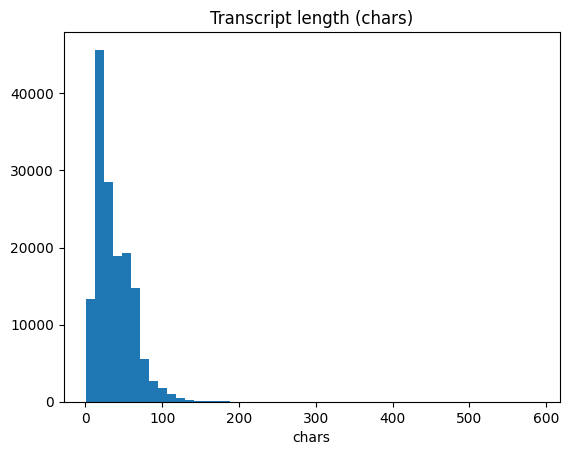

In [9]:
# Transcript length plot
df["char_len"] = df["transcript"].apply(len)
plt.hist(df["char_len"], bins=50)
plt.title("Transcript length (chars)")
plt.xlabel("chars")
plt.show()

In [10]:
df["char_len"].describe()

count    152396.000000
mean         37.462821
std          23.979648
min           1.000000
25%          18.000000
50%          32.000000
75%          53.000000
max         588.000000
Name: char_len, dtype: float64

In [11]:
# Character frequency (top 40)
from collections import Counter

char_counts = Counter("".join(df["transcript"].tolist()))
top = char_counts.most_common(40)
top

[(' ', 834077),
 ('្', 411236),
 ('ា', 362949),
 ('រ', 318411),
 ('ន', 276032),
 ('ប', 275885),
 ('ក', 190610),
 ('ម', 180791),
 ('ល', 167853),
 ('ស', 163856),
 ('់', 132837),
 ('ី', 130068),
 ('យ', 128373),
 ('ង', 126075),
 ('ត', 121450),
 ('ទ', 111404),
 ('ំ', 111363),
 ('ព', 102850),
 ('ុ', 97806),
 ('ូ', 97430),
 ('ិ', 85499),
 ('ច', 85112),
 ('ួ', 80344),
 ('េ', 69754),
 ('ញ', 60385),
 ('ដ', 58218),
 ('វ', 52839),
 ('ខ', 50867),
 ('អ', 50853),
 ('៉', 47894),
 ('ើ', 46108),
 ('ៅ', 45798),
 ('ជ', 45251),
 ('▁', 44621),
 ('ែ', 42969),
 ('ថ', 41102),
 ('គ', 37906),
 ('ណ', 33950),
 ('ៃ', 33356),
 ('ផ', 32914)]

In [12]:
WORD_DELIMITER = "|"
IGNORED_CHARACTERS = [
    "!", "\"", "#", "$", "(", ")", ",", "-", ".", "/", "។", "៕", "៖", "ៗ",
    "០", "១", "២", "៣", "៤", "៥", "៦", "៧", "៨", "៩", "​", "—", "“", "”",
    "취", "[", "]", ":", "?", '…',
    *list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"),
    *list("abcdefghijklmnopqrstuvwxyz"),
]


def build_vocab(texts: Sequence[str], ignored_chars: Sequence[str] = IGNORED_CHARACTERS) -> List[str]:

    ignored_set = set(ignored_chars)
    all_chars = set()

    for text in texts:
        filtered = [ch for ch in text if ch not in ignored_set]
        all_chars.update(filtered)

    chars = sorted(all_chars)
    vocab = ["<pad>", "<blank>"] + chars
    print(f"Vocab built: {len(vocab)} symbols (ignored {len(ignored_set)} chars)")
    return vocab

VOCAB = build_vocab(df["transcript"].tolist())
BLANK_IDX = VOCAB.index("<blank>")
IDX2C = VOCAB
IDX2C

Vocab built: 75 symbols (ignored 86 chars)


['<pad>',
 '<blank>',
 ' ',
 'ក',
 'ខ',
 'គ',
 'ឃ',
 'ង',
 'ច',
 'ឆ',
 'ជ',
 'ឈ',
 'ញ',
 'ដ',
 'ឋ',
 'ឌ',
 'ឍ',
 'ណ',
 'ត',
 'ថ',
 'ទ',
 'ធ',
 'ន',
 'ប',
 'ផ',
 'ព',
 'ភ',
 'ម',
 'យ',
 'រ',
 'ល',
 'វ',
 'ស',
 'ហ',
 'ឡ',
 'អ',
 'ឥ',
 'ឦ',
 'ឧ',
 'ឪ',
 'ឫ',
 'ឬ',
 'ឭ',
 'ឮ',
 'ឯ',
 'ឱ',
 'ា',
 'ិ',
 'ី',
 'ឹ',
 'ឺ',
 'ុ',
 'ូ',
 'ួ',
 'ើ',
 'ឿ',
 'ៀ',
 'េ',
 'ែ',
 'ៃ',
 'ោ',
 'ៅ',
 'ំ',
 'ះ',
 'ៈ',
 '៉',
 '៊',
 '់',
 '៌',
 '៍',
 '៎',
 '៏',
 '័',
 '្',
 '▁']

In [13]:
C2IDX = {
    c:i for i,c in enumerate(VOCAB)
}
C2IDX

{'<pad>': 0,
 '<blank>': 1,
 ' ': 2,
 'ក': 3,
 'ខ': 4,
 'គ': 5,
 'ឃ': 6,
 'ង': 7,
 'ច': 8,
 'ឆ': 9,
 'ជ': 10,
 'ឈ': 11,
 'ញ': 12,
 'ដ': 13,
 'ឋ': 14,
 'ឌ': 15,
 'ឍ': 16,
 'ណ': 17,
 'ត': 18,
 'ថ': 19,
 'ទ': 20,
 'ធ': 21,
 'ន': 22,
 'ប': 23,
 'ផ': 24,
 'ព': 25,
 'ភ': 26,
 'ម': 27,
 'យ': 28,
 'រ': 29,
 'ល': 30,
 'វ': 31,
 'ស': 32,
 'ហ': 33,
 'ឡ': 34,
 'អ': 35,
 'ឥ': 36,
 'ឦ': 37,
 'ឧ': 38,
 'ឪ': 39,
 'ឫ': 40,
 'ឬ': 41,
 'ឭ': 42,
 'ឮ': 43,
 'ឯ': 44,
 'ឱ': 45,
 'ា': 46,
 'ិ': 47,
 'ី': 48,
 'ឹ': 49,
 'ឺ': 50,
 'ុ': 51,
 'ូ': 52,
 'ួ': 53,
 'ើ': 54,
 'ឿ': 55,
 'ៀ': 56,
 'េ': 57,
 'ែ': 58,
 'ៃ': 59,
 'ោ': 60,
 'ៅ': 61,
 'ំ': 62,
 'ះ': 63,
 'ៈ': 64,
 '៉': 65,
 '៊': 66,
 '់': 67,
 '៌': 68,
 '៍': 69,
 '៎': 70,
 '៏': 71,
 '័': 72,
 '្': 73,
 '▁': 74}

In [14]:

def greedy_ctc_decode(logp: torch.Tensor, blank_idx: int) -> List[List[int]]:
    # logp: (B, T, V)
    pred = logp.argmax(dim=-1)  # (B, T)
    hyps = []
    for seq in pred:
        prev = -1
        out = []
        for idx in seq.tolist():
            if idx != prev and idx != blank_idx:
                out.append(idx)
            prev = idx
        hyps.append(out)
    return hyps

def idx2text(indices: List[int]) -> str:
    return "".join(IDX2C[i] for i in indices if 0 <= i < len(IDX2C))


In [15]:
class ASRDataset(torch.utils.data.Dataset):
    def __init__( self, df: pd.DataFrame, vocab: Sequence[str], sr: int, n_mels: int = 80) -> None:
        """
        Dataset that loads audio and converts it to log-Mel spectrograms,
        while tokenizing transcripts using our own vocab
        """
        self.df = df.reset_index(drop=True)
        self.sample_rate = sr
        self.n_mels = n_mels
        
        # Char-to-index mapping
        self.char_to_idx = {c: i for i, c in enumerate(vocab)}
        self.allowed_chars = {c for c in vocab if c not in {"<pad>", "<blank>"}}
        
        # Mel-spectrogram extractor
        # https://docs.pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py
        # https://docs.pytorch.org/audio/stable/generated/torchaudio.transforms.MelSpectrogram.html
        self.mel_extractor = torchaudio.transforms.MelSpectrogram(
            sample_rate=sr,
            n_fft=1014,
            hop_length=256,
            n_mels=n_mels,
            power=2.0,
            center=False
        )
        # convert mel-spectrogram from linear scale (amplitude or power) to logarithmic decibel (db) scale
        # which is what neural networks usually work better with.
        # dB=10×log10​(power) | dB=20×log10​(amplitude)
        self.to_db = torchaudio.transforms.AmplitudeToDB(stype="power")
        
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self, idx: int) -> Tuple[torch.tensor, torch.Tensor]:
        row = self.df.iloc[idx]
        path: Path = row["audio_path"]
        text: str = row["transcript"]
        
        # ----- Load audio -------
        # waveform: a PyTorch tensor of shape (channels, samples)
        waveform, sr = torchaudio.load(path)
        if waveform.size(0) > 1:
            waveform = waveform.mean(dim=0)
        else:
            waveform = waveform.squeeze(0)
        
        if sr != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)
        
        waveform = waveform.clamp(-1.0, 1.0)
        
        # ----- Convert to log-mel spectrogram ---------
        mel = self.mel_extractor(waveform)
        mel_db = self.to_db(mel)
        mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6) # normalize mel_db
        mel_db = mel_db.transpose(0, 1) # (time, n_mels)


        # ----- Tokenize transcript using vocab -------
        filtered = "".join(c for c in text if c in self.allowed_chars)
        if not filtered:
            raise ValueError(f"Transcript at index {idx} has no supported characters: {text!r}")
        label_ids = torch.tensor([self.char_to_idx[c] for c in filtered], dtype=torch.long)
        
        return mel_db, label_ids
        
        


### Visualize

In [16]:
dataset = ASRDataset(df, VOCAB, sr=CFG.sample_rate, n_mels=CFG.n_mels)

# Pick one example
mel_db, label_ids = dataset[0]
print(f"Mel shape: {mel_db.shape}")
print(f"Label ids: {label_ids.tolist()}")

# Reload raw waveform separately for visualization
path = df.iloc[0]["audio_path"]
waveform, sr = torchaudio.load(path)
waveform = waveform.mean(dim=0) if waveform.size(0) > 1 else waveform.squeeze(0)
if sr != CFG.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sr, CFG.sample_rate)
waveform = waveform.clamp(-1, 1)


Mel shape: torch.Size([536, 80])
Label ids: [8, 47, 18, 32, 47, 23, 23, 73, 29, 46, 62, 74, 13, 51, 30, 73, 30, 46, 29, 2, 23, 73, 29, 46, 62, 2, 32, 57, 22, 2, 32, 52, 27, 24, 73, 12, 54, 20, 61, 30, 57, 4, 2, 32, 52, 22, 73, 28, 74, 3, 61, 32, 47, 23, 74, 23, 73, 29, 46, 62, 23, 53, 22, 29, 28, 74, 3, 61, 32, 47, 23, 23, 73, 29, 46, 62, 74, 23, 73, 29, 46, 62, 23, 48, 29, 28, 74, 32, 58, 32, 47, 23, 23, 73, 29, 46, 62, 27, 53, 28]


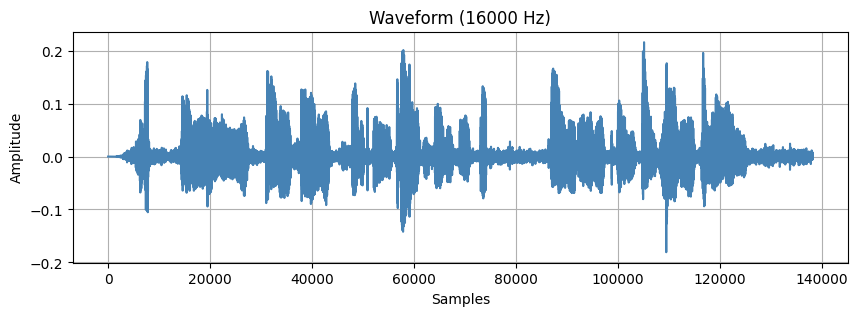

In [17]:
# Plot the raw waveform
plt.figure(figsize=(10, 3))
plt.plot(waveform.numpy(), color="steelblue")
plt.title(f"Waveform ({CFG.sample_rate} Hz)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


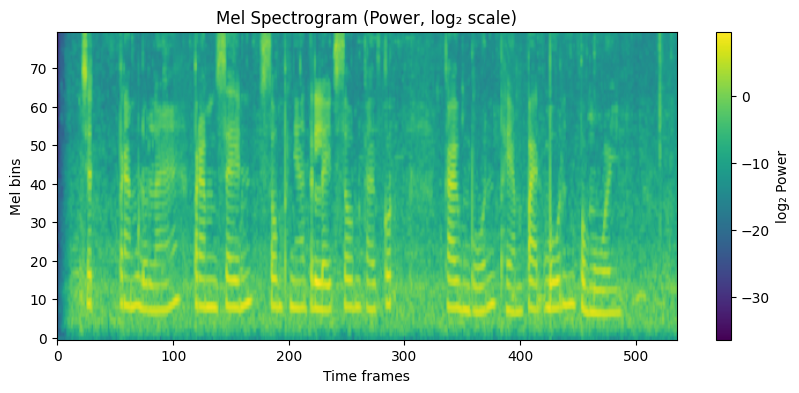

In [18]:
# Plot the linear Mel spectrogram (power)

mel_extractor = dataset.mel_extractor
mel_power = mel_extractor(waveform)

plt.figure(figsize=(10, 4))
plt.imshow(mel_power.log2().numpy(), aspect="auto", origin="lower", cmap="viridis")
plt.title("Mel Spectrogram (Power, log₂ scale)")
plt.xlabel("Time frames")
plt.ylabel("Mel bins")
plt.colorbar(label="log₂ Power")
plt.show()

The frequency content over time, with brighter colors = higher energy.
Speech shows vertical striations (formants, harmonics).

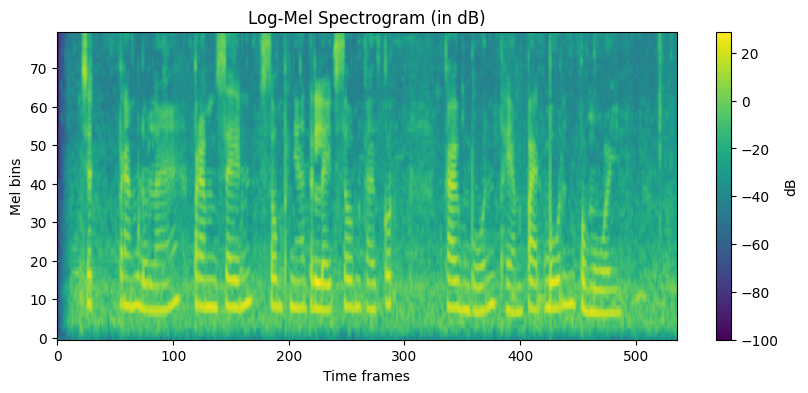

In [55]:
to_db = dataset.to_db
mel_db = to_db(mel_power)

plt.figure(figsize=(10, 4))
plt.imshow(mel_db.numpy(), aspect="auto", origin="lower", cmap="viridis")
plt.title("Log-Mel Spectrogram (in dB)")
plt.xlabel("Time frames")
plt.ylabel("Mel bins")
plt.colorbar(label="dB")
plt.show()


Same as before, but now in decibels (log scale) —
much more visually balanced, because small differences in quiet regions become visible.

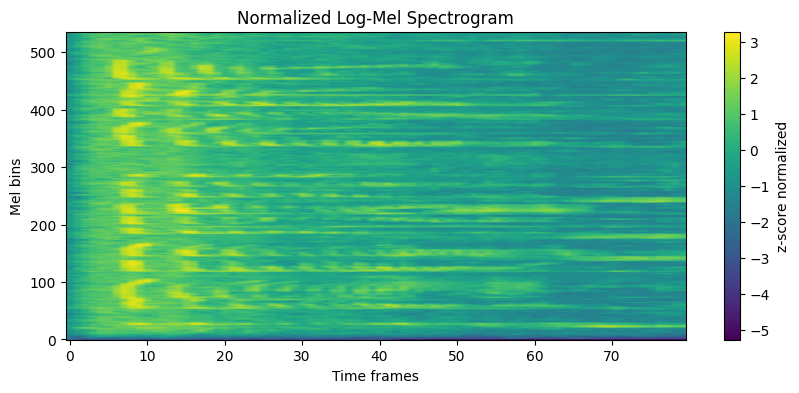

In [20]:
# Plot Normalized Log-Mel Features
mel_norm = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)

plt.figure(figsize=(10, 4))
plt.imshow(mel_norm.numpy(), aspect="auto", origin="lower", cmap="viridis")
plt.title("Normalized Log-Mel Spectrogram")
plt.xlabel("Time frames")
plt.ylabel("Mel bins")
plt.colorbar(label="z-score normalized")
plt.show()



In [21]:
# Map back label indices → characters
decoded_text = "".join(VOCAB[i] for i in label_ids.tolist())

print("Original transcript:", df.iloc[0]["transcript"])
print("Filtered transcript:", decoded_text)
print("Encoded label IDs:", label_ids.tolist())


Original transcript: ចិតសិបប្រាំ▁ដុល្លារ ប្រាំ សេន សូមផ្ញើទៅលេខ សូន្យ▁កៅសិប▁ប្រាំបួនរយ▁កៅសិបប្រាំ▁ប្រាំបីរយ▁សែសិបប្រាំមួយ
Filtered transcript: ចិតសិបប្រាំ▁ដុល្លារ ប្រាំ សេន សូមផ្ញើទៅលេខ សូន្យ▁កៅសិប▁ប្រាំបួនរយ▁កៅសិបប្រាំ▁ប្រាំបីរយ▁សែសិបប្រាំមួយ
Encoded label IDs: [8, 47, 18, 32, 47, 23, 23, 73, 29, 46, 62, 74, 13, 51, 30, 73, 30, 46, 29, 2, 23, 73, 29, 46, 62, 2, 32, 57, 22, 2, 32, 52, 27, 24, 73, 12, 54, 20, 61, 30, 57, 4, 2, 32, 52, 22, 73, 28, 74, 3, 61, 32, 47, 23, 74, 23, 73, 29, 46, 62, 23, 53, 22, 29, 28, 74, 3, 61, 32, 47, 23, 23, 73, 29, 46, 62, 74, 23, 73, 29, 46, 62, 23, 48, 29, 28, 74, 32, 58, 32, 47, 23, 23, 73, 29, 46, 62, 27, 53, 28]


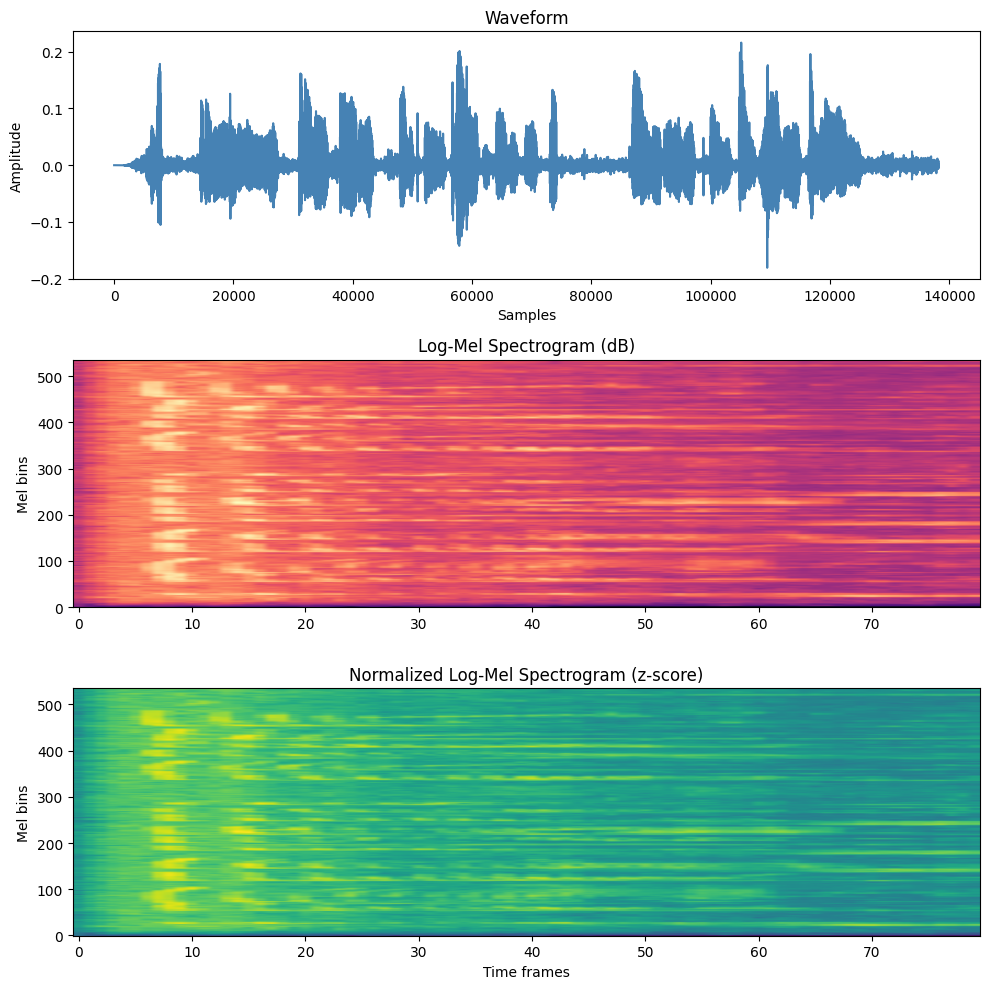

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# waveform
axes[0].plot(waveform.numpy(), color="steelblue")
axes[0].set_title("Waveform")
axes[0].set_xlabel("Samples")
axes[0].set_ylabel("Amplitude")

# mel (dB)
axes[1].imshow(mel_db.numpy(), aspect="auto", origin="lower", cmap="magma")
axes[1].set_title("Log-Mel Spectrogram (dB)")
axes[1].set_ylabel("Mel bins")

# mel normalized
axes[2].imshow(mel_norm.numpy(), aspect="auto", origin="lower", cmap="viridis")
axes[2].set_title("Normalized Log-Mel Spectrogram (z-score)")
axes[2].set_xlabel("Time frames")
axes[2].set_ylabel("Mel bins")

plt.tight_layout()
plt.show()


## Collate func

In [27]:
def pad_spectrograms(batch: Sequence[torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
    # lengths: (B,)
    lengths = torch.tensor([spec.size(0) for spec in batch], dtype=torch.long)
    max_len = int(lengths.max().item())          # <-- () + .item()
    n_mels = int(batch[0].size(1))

    # Shape: (B, T_max, n_mels)
    padded = torch.zeros(len(batch), max_len, n_mels, dtype=batch[0].dtype)
    for i, spec in enumerate(batch):
        T = spec.size(0)
        padded[i, :T] = spec
    return padded, lengths


def collate_batch(batch: Sequence[tuple[torch.Tensor, torch.Tensor]]):
    specs, labels = zip(*batch)

    padded_specs, spec_lengths = pad_spectrograms(specs)

    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)
    max_label_len = int(label_lengths.max().item())

    padded_labels = torch.zeros(len(labels), max_label_len, dtype=torch.long)
    for i, l in enumerate(labels):
        L = len(l)
        padded_labels[i, :L] = l

    return padded_specs, spec_lengths, padded_labels, label_lengths


In [24]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Create dataset and dataloader
dataset = ASRDataset(df, VOCAB, sr=CFG.sample_rate, n_mels=CFG.n_mels)

loader = DataLoader(
    dataset,
    batch_size=4,                # small batch for visualization
    shuffle=True,
    collate_fn=collate_batch, 
)

# Get one batch
specs, spec_lens, labels, label_lens = next(iter(loader))
print("Batch specs shape:", specs.shape)
print("Spec lengths:", spec_lens.tolist())


Batch specs shape: torch.Size([4, 203, 80])
Spec lengths: [203, 132, 83, 123]


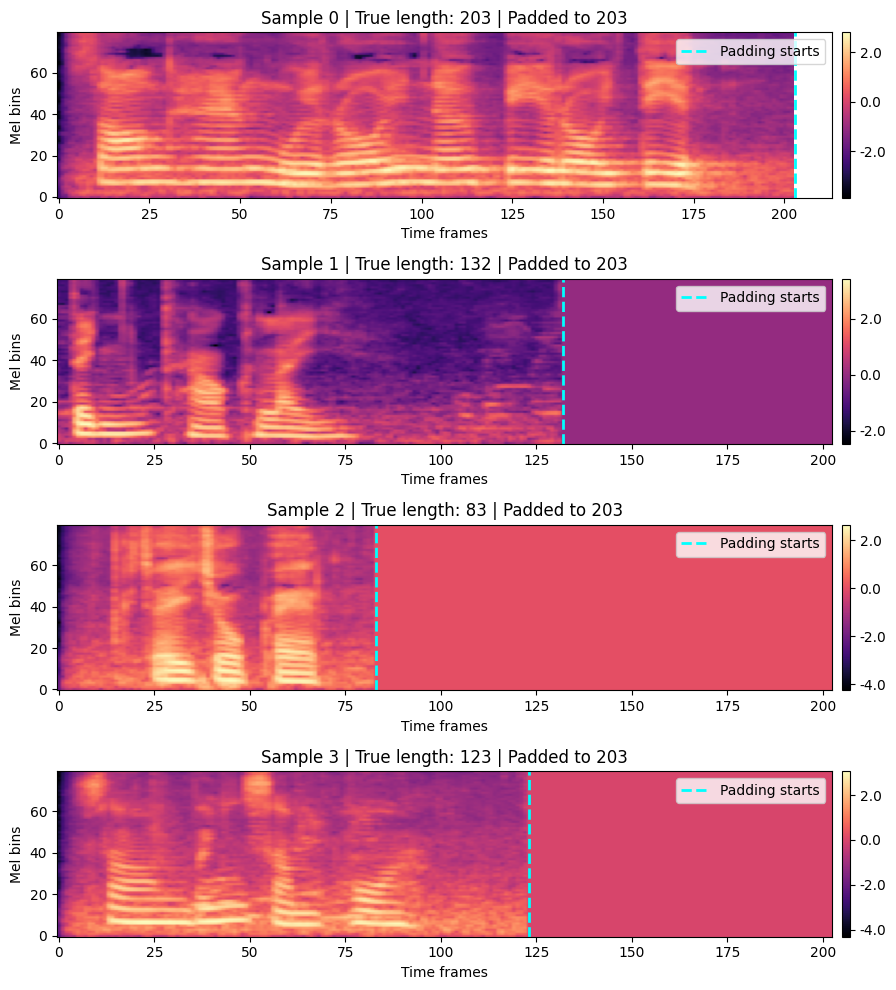

In [28]:
num_examples = len(specs)
fig, axes = plt.subplots(num_examples, 1, figsize=(10, 2.5 * num_examples))

for i in range(num_examples):
    spec = specs[i].T.numpy()           # (n_mels, T)
    true_len = spec_lens[i].item()
    
    ax = axes[i] if num_examples > 1 else axes
    im = ax.imshow(spec, aspect="auto", origin="lower", cmap="magma")
    
    # Mark padded region (beyond true_len)
    ax.axvline(true_len, color="cyan", linestyle="--", linewidth=2, label="Padding starts")
    
    ax.set_title(f"Sample {i} | True length: {true_len} | Padded to {spec.shape[1]}")
    ax.set_xlabel("Time frames")
    ax.set_ylabel("Mel bins")
    ax.legend(loc="upper right")
    
    fig.colorbar(im, ax=ax, format="%.1f", pad=0.01)

plt.tight_layout()
plt.show()


## Model Achitecture | DeepSpeech2

In [ ]:
class LogMelExtractor(nn.Module):
    def __init__(self, CFG) -> None:
        super().__init__()
        self.spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=
        )

## Error Function

In [29]:
def greedy_decode(log_probs: torch.Tensor, blank_idx: int) -> List[List[int]]:
    predictions: List[List[int]] = []
    for sequence in log_probs.argmax(dim=-1):
        prev = -1
        decoded: List[int] = []
        for idx in sequence.tolist():
            if idx != prev and idx != blank_idx:
                decoded.append(idx)
            prev = idx
        predictions.append(decoded)
    return predictions


def indices_to_text(indices: List[int], vocab: Sequence[str]) -> str:
    return "".join(vocab[idx] for idx in indices if 0 <= idx < len(vocab))


In [30]:
def levenshtein_distance(ref: Sequence[str], hyp: Sequence[str]) -> int:
    if not ref:
        return len(hyp)
    if not hyp:
        return len(ref)

    previous = list(range(len(hyp) + 1))
    current = [0] * (len(hyp) + 1)

    for i, ref_token in enumerate(ref, start=1):
        current[0] = i
        for j, hyp_token in enumerate(hyp, start=1):
            cost = 0 if ref_token == hyp_token else 1
            deletion = previous[j] + 1
            insertion = current[j - 1] + 1
            substitution = previous[j - 1] + cost
            current[j] = min(deletion, insertion, substitution)
        previous, current = current, previous

    return previous[-1]

In [31]:
def compute_error_rates(pairs: Sequence[Tuple[str, str]]) -> Tuple[float, float]:
    word_distance = 0
    word_total = 0
    char_distance = 0
    char_total = 0

    for hyp, ref in pairs:
        ref_words = ref.split()
        hyp_words = hyp.split()
        word_distance += levenshtein_distance(ref_words, hyp_words)
        word_total += len(ref_words)

        ref_chars = list(ref)
        hyp_chars = list(hyp)
        char_distance += levenshtein_distance(ref_chars, hyp_chars)
        char_total += len(ref_chars)

    wer = word_distance / word_total if word_total else 0.0
    cer = char_distance / char_total if char_total else 0.0
    return wer, cer

In [ ]:
def append_eval_metrics(path: Path, epoch: int, val_loss: float, wer: float, cer: float) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("a", encoding="utf-8") as handle:
        handle.write(
            f"epoch={epoch} val_loss={val_loss:.4f} WER={wer:.4f} CER={cer:.4f}\n"
        )
        
def pack_targets(labels: Sequence[torch.Tensor], device: torch.device) -> Tuple[torch.Tensor, torch.Tensor]:
    lengths = torch.tensor([label.numel() for label in labels], dtype=torch.long, device=device)
    if torch.any(lengths == 0):
        raise ValueError("Empty transcription encountered; ensure transcripts contain at least one symbol.")
    packed = torch.cat([label.to(device) for label in labels])
    return packed, lengths



## Save model

## Inference

## Benchmark

In [25]:
# Run running with Benchmark dataset to calculate WER, RTFx